Met Office MOGREPS data
=============

The Met Office has made data from its world leading MOGPREPS weather model available for research purposes. In this page, we'll go over the basics of how to download the data, how you can look at it, and what it means.

Data from two models is available:

1. MOGREPS-UK: a high resolution weather forecast covering the UK, and
1. MOGREPS-G: a global weather forecast.

Amazon Web Services are kindly hosting this data for free as part of their Open Data Initiative. Depending on the usage they reserve the right to swap to a 'Requestor Pays' model, which will disallow anonymous access.

## How is the data structured?
Our weather forecast models predict many weather parameters, such as air temperature, humidity or rainfall. These are predicted for every point on a regular grid, that is, as a function of latitude, longitude, and (when appropriate) altitude.

With the advent of our latest supercomputer, we now regularly run "ensemble forecasts". This means that instead of starting one model run now to predict tomorrow, we start many, purturbing the intial parameters to give several possible futures (or *realisations*). The spread of these different realisations gives an indication of the uncertainty of the forecast, and can be very powerful information.

![](./images/ensemble_forecasting_schematic.png)


Each forecast point also has several measures of time. Firstly, `time` indicates the real world time that the data is forecast for. Secondly, `reference_time` is the time that the forecast was started from i.e. the 0th `time` point. Finally, `forecast_period` is the difference between the two i.e. the number of hours that have elapsed since the start of the forecast.

## Downloading data
Here, we'll show you a simple way to download files using Python. The data is stored in AWS S3 buckets hosted in the eu-west-2 region, named `mogreps-uk` and `mogreps-g`. If that doesn't mean anything to you, don't worry - have a look at the Python functions below.

`make_data_object_name` takes infomation about the data you are looking for and constructs it into a data object name (you can think of this as a file name). We'll go into what things like forecast_period and realization are in a minute. `download data` then saves this object to the same directory as your notebook. 

In [1]:
import urllib.request

def make_data_object_name(dataset_name, year, month, day, hour, forecast_period, realization):
    template_string = "prods_op_{}_{:02d}{:02d}{:02d}_{:02d}_{:02d}_{:03d}.nc"
    return template_string.format(dataset_name, year, month, day, hour, forecast_period, realization)

def download_data_object(dataset_name, data_object_name):
    url = "https://s3.eu-west-2.amazonaws.com/" + dataset_name + "/" + data_object_name
    urllib.request.urlretrieve(url, data_object_name) # save in this directory with same name

Note that you can also use Python modules such as Boto to list, filter and retrieve these files.

We'll use these functions to download one data object.

In [2]:
obj_name = make_data_object_name('mogreps-uk', 2013, 1, 1, 3, 0, 3)
download_data_object('mogreps-uk', obj_name)

and here is is.

In [3]:
!ls -ltrh {obj_name}

-rw-r--r--  1 alex  staff    22M Jun 20 10:54 prods_op_mogreps-uk_20130101_03_00_003.nc


## Loading Data

This data is in NetCDF format, which is a type of the widely used HDF format. You can use any compatible tools, but we recommend the Met Office's Iris Python module. First of all, let's make sure we've got Iris instaled using Conda.

In [4]:
!conda install -y -c conda-forge iris

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/alex/anaconda3:
#
iris                      1.13.0                   py35_1    conda-forge


Now let's load the file we just downloaded

In [5]:
import iris
mydata = iris.load("./prods_op_mogreps-uk_20130101_03_00_003.nc")

print(mydata)

/Users/alex/anaconda3/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


0: wet_bulb_freezing_level_altitude / (m) (time: 3; grid_latitude: 548; grid_longitude: 421)
1: cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 4; grid_latitude: 548; grid_longitude: 421)
2: wet_bulb_potential_temperature / (K) (time: 4; pressure: 3; grid_latitude: 548; grid_longitude: 421)
3: stratiform_snowfall_rate / (kg m-2 s-1) (time: 36; grid_latitude: 548; grid_longitude: 421)
4: cloud_area_fraction_assuming_maximum_random_overlap / (1) (time: 4; grid_latitude: 548; grid_longitude: 421)
5: air_pressure_at_sea_level / (Pa)    (time: 4; grid_latitude: 548; grid_longitude: 421)
6: air_temperature / (K)               (time: 3; grid_latitude: 548; grid_longitude: 421)
7: air_temperature / (K)               (time: 3; grid_latitude: 548; grid_longitude: 421)
8: air_temperature / (K)               (time: 4; grid_latitude: 548; grid_longitude: 421)
9: air_temperature / (K)               (time: 4; pressure: 2; grid_latitude: 548; grid_l

You can see here that the object we have loaded from our file contains many different meteorological parameters. iris.load returns a 'CubeList' object, which is essentially a list with a few helper methods.

## Exploring Data

We can find our more information about a particular parameter...

In [6]:
air_temps = mydata.extract('air_temperature')
print(air_temps)

0: air_temperature / (K)               (time: 3; grid_latitude: 548; grid_longitude: 421)
1: air_temperature / (K)               (time: 3; grid_latitude: 548; grid_longitude: 421)
2: air_temperature / (K)               (time: 4; grid_latitude: 548; grid_longitude: 421)
3: air_temperature / (K)               (time: 4; pressure: 2; grid_latitude: 548; grid_longitude: 421)


So there are four different forecasts for 'air_temperature'. I'll show how to dig into them, but essentially there are three forecasts for ground level, and one for particular pressure levels in the atmosphere.

The three ground level forecasts are:
- minimum forecasted value over an hour period
- maximum forecasted value over an hour period
- forecast for an exact snapshot in time

Lets grab the snapshot forecast

In [12]:
surface_temp = air_temps[2]
print(surface_temp)

air_temperature / (K)               (time: 4; grid_latitude: 548; grid_longitude: 421)
     Dimension coordinates:
          time                           x                 -                    -
          grid_latitude                  -                 x                    -
          grid_longitude                 -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                 -                    -
     Scalar coordinates:
          forecast_reference_time: 2013-01-01 03:00:00
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i236
          source: Data from Met Office Unified Model
          um_version: 7.9


So here's the metadata for our chosen cube. We can see a lot of information here. 

- The cube shape is (4 x 548 x 421)
- There are three numeric dimension coordinates (time, grid_latitude, grid_longitude)
- There are two coordinates that are not linked to a dimension (forecast_reference_time, height)

We can drill into the cube in various ways:

In [13]:
print(surface_temp.coord('time'))

DimCoord([2013-01-01 03:01:00, 2013-01-01 04:00:00, 2013-01-01 05:00:00,
       2013-01-01 06:00:00], standard_name='time', calendar='gregorian', var_name='time_0')


And here's the underlying numpy array:

In [14]:
surface_temp.data

array([[[ 284.125,  284.125,  284.125, ...,  280.75 ,  280.75 ,  280.75 ],
        [ 284.   ,  284.   ,  284.   , ...,  280.75 ,  280.75 ,  280.75 ],
        [ 284.   ,  284.   ,  284.   , ...,  280.75 ,  280.75 ,  280.75 ],
        ..., 
        [ 280.875,  280.875,  280.875, ...,  279.125,  279.125,  279.125],
        [ 280.875,  280.875,  280.875, ...,  279.125,  279.125,  279.125],
        [ 280.875,  280.875,  280.875, ...,  279.125,  279.125,  279.125]],

       [[ 284.25 ,  284.25 ,  284.25 , ...,  281.   ,  281.125,  281.   ],
        [ 284.25 ,  284.25 ,  284.25 , ...,  281.125,  281.125,  281.   ],
        [ 284.25 ,  284.25 ,  284.25 , ...,  281.125,  281.   ,  281.   ],
        ..., 
        [ 281.125,  281.125,  281.125, ...,  279.125,  279.125,  279.125],
        [ 281.125,  281.125,  281.125, ...,  279.125,  279.125,  279.125],
        [ 281.125,  281.125,  281.125, ...,  279.125,  279.125,  279.125]],

       [[ 284.375,  284.375,  284.375, ...,  281.125,  281.125,  281

You can slice a cube by index to extract particular pieces of data:

In [15]:
# The first forecast in the dataset
print(surface_temp[0])

air_temperature / (K)               (grid_latitude: 548; grid_longitude: 421)
     Dimension coordinates:
          grid_latitude                           x                    -
          grid_longitude                          -                    x
     Scalar coordinates:
          forecast_period: 0.0166666656733 hours
          forecast_reference_time: 2013-01-01 03:00:00
          height: 1.5 m
          time: 2013-01-01 03:01:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i236
          source: Data from Met Office Unified Model
          um_version: 7.9


In [16]:
# All forecasts for a particular point:
print(surface_temp[:, 100, 300])

air_temperature / (K)               (time: 4)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 2013-01-01 03:00:00
          grid_latitude: -1.77995 degrees
          grid_longitude: 360.911 degrees
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i236
          source: Data from Met Office Unified Model
          um_version: 7.9


## Plotting Data

Iris also has built-in functions to make plotting the cube easier:

/Users/alex/anaconda3/lib/python3.5/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/alex/anaconda3/lib/python3.5/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


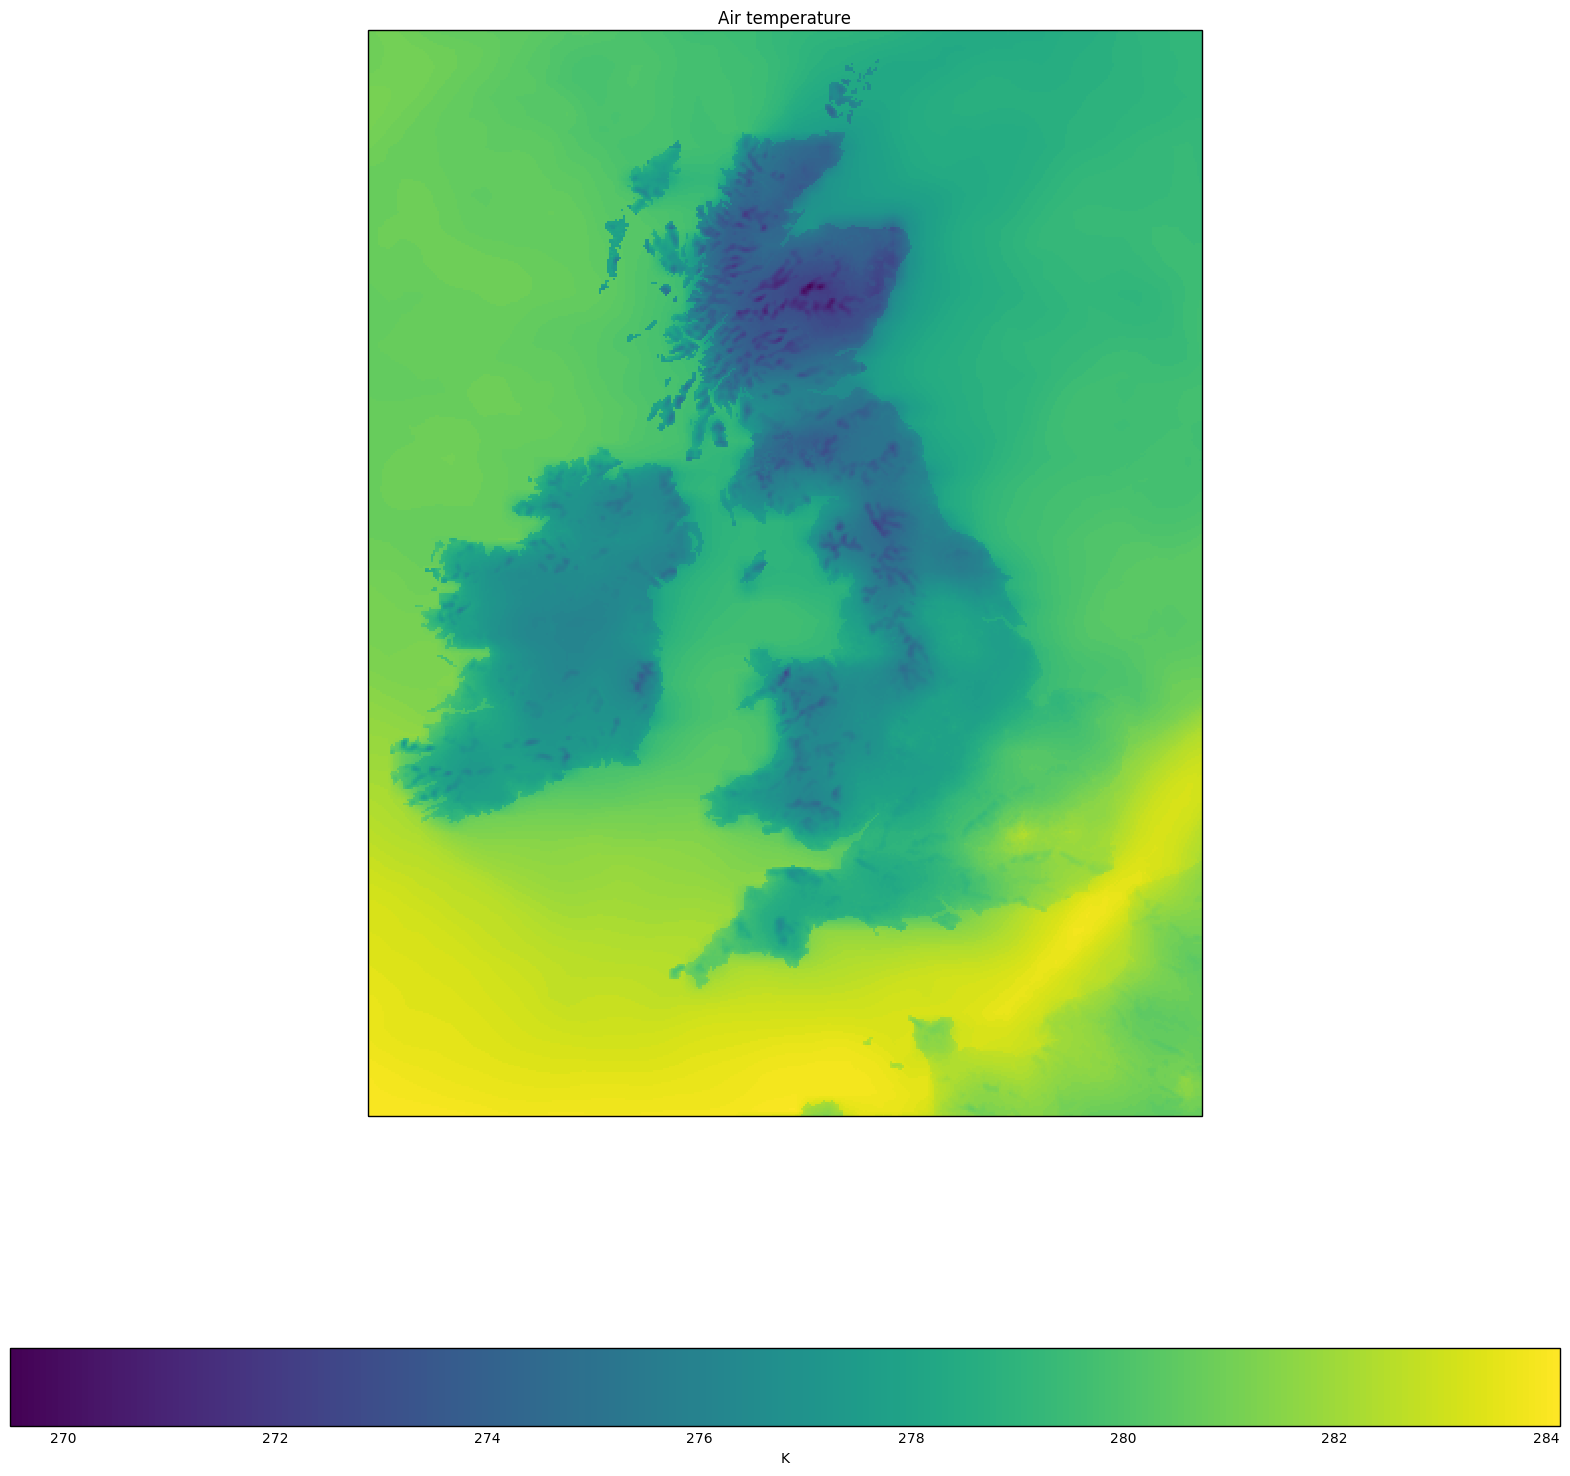

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import iris.quickplot as qplt

# Set the size of the plot
plt.figure(figsize=(20, 20))

# Select the first forecast
time_slice = surface_temp[0]

# iris quickplot sets up our axes and labels so we don't have to
qplt.pcolormesh(time_slice, cmap='viridis')


## Finally...

We hope you found this page a useful introduction. Please have a look at the data page, where you can find other notebooks covering more advance uses. In particular the Met Office Informatics Lab are working on distributed cloud computing using Iris and Dask.

You can find the Iris reference documentation, a user guide and examples at http://scitools.org.uk/iris/docs/latest/index.html. There's also more information about the Met Office models at http://www.metoffice.gov.uk/research/weather/ensemble-forecasting/mogreps.

This data is free to use for research purposes only, and not for profit making applications. Any derived products should acknowledge the use of Met Office data. No ongoing level of support is implied and data may be changed or removed without notice.